# How lit is Stephen King?

Code for the LaTeCH 2021 paper Stylometric Literariness Classification: the Case of Stephen King.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import dendrogram
from sklearn import feature_extraction, preprocessing, pipeline, decomposition, metrics, manifold, cluster, linear_model, model_selection, neighbors, dummy
import seaborn as sns
import bokeh.plotting as bp
import bokeh.io
from bokeh import palettes
from bokeh.models import HoverTool, BoxSelectTool, ColorBar, CategoricalColorMapper, LinearColorMapper, PrintfTickFormatter
from bokeh.transform import linear_cmap, factor_cmap
from bokeh.plotting import figure, show
from bokeh.resources import INLINE, CDN
bokeh.io.reset_output()

def scatter(reduced):
    """A static scatter plots with short labels for datapoints."""
    fig, ax = plt.subplots(figsize=(13, 9))
    for key, row in reduced.loc[high, :].iterrows(): ax.scatter(row[0], row[1], alpha=0); ax.annotate(key.split()[1].strip(','), xy=(row[0], row[1]), c='b')
    for key, row in reduced.loc[pop, :].iterrows(): ax.scatter(row[0], row[1], alpha=0); ax.annotate(key.split()[1].strip(','), xy=(row[0], row[1]), c='r')
    for key, row in reduced.loc[king, :].iterrows(): ax.scatter(row[0], row[1], alpha=0); ax.annotate(key.split()[0], xy=(row[0], row[1]), c='g')
    ax.legend(loc='upper left', handles=[mpatches.Patch(color='b', label='high lit'), mpatches.Patch(color='r', label='pop fic'), mpatches.Patch(color='g', label='king')]);
    return fig


def scatter2(data, x, y, hue, title, outfile):  # .html file
    """An interactive scatter plot with categorical/qualitative colors and popups with details.
    
    :param hue: a column with categories, used to select colors.
    """
    plot = bp.figure(plot_width=900, plot_height=700,
            title=title,
            tools='pan,wheel_zoom,box_zoom,reset,hover,save',
            x_axis_type=None, y_axis_type=None, min_border=1)
    plot.scatter(x=x, y=y, size=10,
            color=factor_cmap(hue, palette=sns.color_palette('deep', as_cmap=True),
                              factors=['high', '', 'king', 'pop']), # factors=sorted(data[hue].unique())),
            legend_field=hue, line_color='white', fill_alpha=0.7, # radius=.1,
            source=bp.ColumnDataSource(data))
    hover = plot.select(dict(type=HoverTool))
    hover.tooltips = {'Info': '@Text @%s @author @year literariness=@literariness' % hue}
    bokeh.io.output_file(outfile)
    bokeh.io.save(plot, filename=outfile, title=title, resources=CDN)


def plot_dendrogram(model, labels, ax, catdict, colormap):
    """Create linkage matrix and then plot the dendrogram
    
    :param catdict: a mapping from labels to categories
    :param colormap: a mapping from categories to colors."""
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, orientation='left', ax=ax, labels=labels, leaf_font_size=14, link_color_func=lambda _: 'k')
    # Code borrowed from https://github.com/cophi-wue/pydelta/blob/next/delta/graphics.py
    labels = ax.get_ymajorticklabels()
    display_labels = []
    for label in labels:
        group = catdict[label.get_text()]
        label.set_color(colormap[group])
        display_label = label.get_text()
        label.set_text(display_label)       # doesn't really set the labels
        display_labels.append(display_label)
    ax.set_yticklabels(display_labels)

## Dataset loading and preprocessing

In [2]:
# Load data
X = pd.read_csv('bow5000.csv', index_col=0)
Xcategory_ = X.category_
X = X.drop(columns=['category_'])
MFW = 1000
X = X.iloc[:, :MFW]
Xtrain = X.loc[Xcategory_.isin({'high', 'pop'}), :]
# Turn word counts into z-scores based on training set
scaler = pipeline.Pipeline([
        ('norm', preprocessing.Normalizer(norm='l2')),
        ('scale', preprocessing.StandardScaler())])
scaler.fit(Xtrain)
# Apply z-scoring to whole corpus
X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)
X_king = X.loc[Xcategory_ == 'king', :]
X_high = X.loc[Xcategory_ == 'high', :]
X_pop = X.loc[Xcategory_ == 'pop', :]
king = X_king.index
high = X_high.index
pop = X_pop.index
print(Xcategory_.value_counts())

king    73
high    38
pop     36
Name: category_, dtype: int64


In [3]:
# Metadata for King corpus
md = pd.read_csv('metadata.csv', index_col=0)
assert (md.index == king).all()
# Metadata for whole corpus
md1 = md.reindex(X.index).fillna('')
md1['author'] = [a or b.split()[1].rstrip(',') for a, b in zip(md1['author'], md1.index)]
md1['year'] = [int(a or b.split()[0]) for a, b in zip(md1['year'], md1.index)]
md1

,year,author,literariness
K01 Carrie,1974,King,
K02 Salem's Lot,1975,King,
K03 The Shining,1977,King,high
K04 Rage,1977,Bachman,pop
K05 The Long Walk,1979,Bachman,
...,...,...,...
"2012 Crais, Robert, Taken",2012,Crais,
"2012 Grisham, John, The Racketeer",2012,Grisham,
"2013 Crais, Robert, Suspect",2013,Crais,
"2016 Connelly, Michael, The Wrong Side of Goodbye",2016,Connelly,


In [4]:
# All the King texts for which we have literariness labels
md[~md.literariness.isna()].reset_index()

,label,year,author,literariness
0,K03 The Shining,1977,King,high
1,K04 Rage,1977,Bachman,pop
2,K06 The Dead Zone,1979,King,high
3,K07 Firestarter,1980,King,pop
4,K09 Cujo,1981,King,pop
5,K10 The Running Man,1982,Bachman,pop
6,K11 Rita Hayworth,1982,King,high
7,K15 Christine,1983,King,pop
8,K16 Pet Sematary,1983,King,high
9,K17 The Eyes of the Dragon,1984,King,pop


In [5]:
# The Stephen King novels
X_king.index

Index(['K01 Carrie', 'K02 Salem's Lot', 'K03 The Shining', 'K04 Rage',
       'K05 The Long Walk', 'K06 The Dead Zone', 'K07 Firestarter',
       'K08 Roadwork', 'K09 Cujo', 'K10 The Running Man', 'K11 Rita Hayworth',
       'K12 Apt Pupil', 'K13 The Body', 'K14 The Breathing Method',
       'K15 Christine', 'K16 Pet Sematary', 'K17 The Eyes of the Dragon',
       'K18 Thinner', 'K19 It', 'K20 DT2 The Drawing of the Three',
       'K21 Misery', 'K22 The Tommyknockers', 'K23 The Dark Half',
       'K24 The Stand', 'K25 The Langoliers',
       'K26 Secret Window Secret Garden', 'K27 The Library Policeman',
       'K28 The Sun Dog', 'K29 DT3 The Waste Lands', 'K30 Needful Things',
       'K31 Gerald's Game', 'K32 Dolores Claiborne', 'K33 Insomnia',
       'K34 Rose Madder', 'K35 The Green Mile', 'K36 Desperation',
       'K37 The Regulators', 'K38 DT4 Wizard and Glass', 'K39 Bag of Bones',
       'K40 The Girl Who Loved Tom Gordon', 'K41 Low Men in Yellow Coats',
       'K42 Hearts In Atl

In [6]:
pop

Index(['1979 Straub, Peter, Ghost Story', '1980 Crichton, Michael, Congo',
       '1981 HarrisT, Thomas, Red Dragon',
       '1984 Clancy, Tom, The Hunt for Red October',
       '1988 DeMille, Nelson, The Charm School', '1988 Straub, Peter, Koko',
       '1990 Rice, Anne, The Witching Hour',
       '1991 Grafton, Sue, H Is for Homicide', '1991 Grisham, John, The Firm',
       '1992 Cornwell, Patricia, All That Remains',
       '1994 Folsom, Allan, The Day After Tomorrow', '1994 Rice, Anne, Taltos',
       '1997 Patterson, James, Cat and Mouse', '1998 Clancy, Tom, Rainbow six',
       '1998 Folsom, Allan, Day of Confession', '1998 Koontz, Dean, Lightning',
       '1999 Crichton, Michael, Timeline', '1999 HarrisT, Thomas, Hannibal',
       '2000 Coulter, Catherine, Riptide', '2000 Evanovich, Janet, Hot Six',
       '2001 Connelly, Michael, A Darkness More Than Night',
       '2001 Johansen, Iris, Final Target',
       '2002 Koontz, Dean, By the Light of the Moon',
       '2004 DeMille, N

In [7]:
high

Index(['1970 O'Brien, Tim, Going After Cacciato',
       '1974 Heinemann, Larry, Close Quarters',
       '1974 Pynchon, Thomas, Gravity's Rainbow',
       '1975 Stone, Robert, Dog Soldiers',
       '1980 Irving, John, The World According to Garp',
       '1982 Johnson_C, Charles, Oxherding Tale',
       '1982 Walker, Alice, The Color Purple',
       '1987 Heinemann, Larry, Paco's Story',
       '1987 McDermott, Alice, That Night', '1988 Dexter, Pete, Paris Trout',
       '1989 Casey, John, Spartina',
       '1989 Irving, John, Prayer for Owen Meany',
       '1989 Walker, Alice, The Temple of My Familiar',
       '1990 Johnson_C, Charles R., Middle Passage',
       '1991 Johnson_D, Denis, Resuscitation of a Hanged Man',
       '1994 O'Brien, Tim, In the Lake of the Woods',
       '1995 Dexter, Pete, The Paperboy', '1995 Powers, Richard, Galatea 2.2',
       '1997 Frazier, Charles, Cold Mountain',
       '1998 McDermott, Alice, Charming Billy',
       '1998 Stone, Robert, Damascus Gate',

In [8]:
# So, what are the most frequent words in the corpus as a whole?
print(' '.join(X.columns))

the and to a of i he in was it you his that she her on had with for said at but as him my not me they out is from up what be this have were all we one if like there no about when or so would then back them could into an by been know do just down don't who now your time their over are did get i'm how see got more two didn't some here off it's man right way looked where can even too say go only through think after around other good before never little going than thought which still again want something come old us head first door away well made people asked will went eyes room told long look knew tell saw came that's took hand much our face left any house why he'd you're because put make might take maybe day very turned another nothing he's has night three himself new felt wasn't thing behind its own while things looking i'd years those i'll car these life place last sure always wanted yes found let home anything heard side every front few enough same white hands father work woman though

In [9]:
# reduce subcorpora to one mean vector each (centroid).
popvec = X_pop.mean(axis=0)
highvec = X_high.mean(axis=0)

In [10]:
popvec

the       0.132860
and      -0.106893
to        0.178616
a        -0.171619
of       -0.389306
            ...   
size     -0.122572
paris    -0.105025
view      0.167316
funny    -0.463655
marino    0.175982
Length: 1000, dtype: float64

In [11]:
highvec

the      -0.125868
and       0.101267
to       -0.169215
a         0.162587
of        0.368816
            ...   
size      0.116121
paris     0.099497
view     -0.158510
funny     0.439252
marino   -0.166719
Length: 1000, dtype: float64

## Exploratory analysis (unsupervised)

In [12]:
# Select lowest KL divergence https://lvdmaaten.github.io/tsne/
result = []
for n in range(10):
    dec = manifold.TSNE(n_components=2, perplexity=15, learning_rate=X.shape[0] / 48, metric='cosine', random_state=n, square_distances=True, method='exact')  # , init='pca')
    reduced = pd.DataFrame(dec.fit_transform(X), index=X.index, columns=['0', '1'])
    result.append(dec.kl_divergence_)
    print('random_state:', n, 'KL divergence:', dec.kl_divergence_)
best = np.argmin(result)

random_state: 0 KL divergence: 0.4521906008204579
random_state: 1 KL divergence: 0.4343329771412
random_state: 2 KL divergence: 0.44469674651201635
random_state: 3 KL divergence: 0.4502428877716155
random_state: 4 KL divergence: 0.4720435942591141
random_state: 5 KL divergence: 0.46158183563048105
random_state: 6 KL divergence: 0.45711072439656814
random_state: 7 KL divergence: 0.45270593304352263
random_state: 8 KL divergence: 0.4755177141005138
random_state: 9 KL divergence: 0.4394207007148162


KL divergence: 0.4343329771412


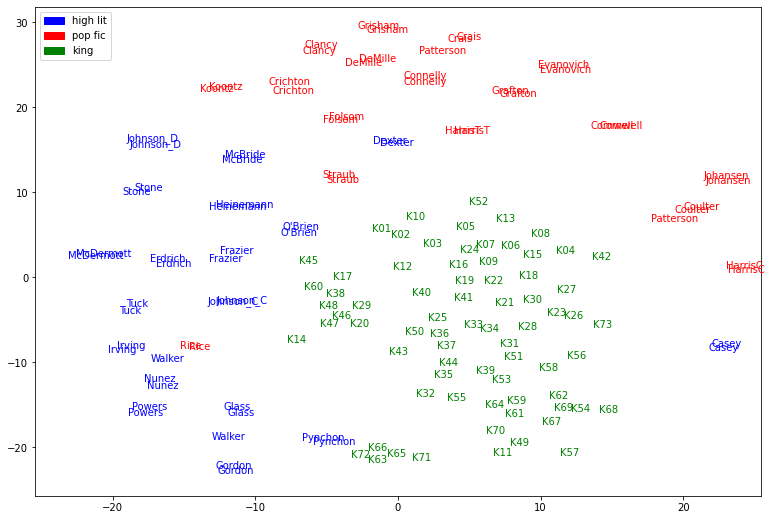

In [13]:
dec = manifold.TSNE(n_components=2, perplexity=15, learning_rate=len(reduced) / 48, metric='cosine', random_state=best, square_distances=True, method='exact')  # , init='pca')
reduced = pd.DataFrame(dec.fit_transform(X), index=X.index, columns=['0', '1'])
print('KL divergence:', dec.kl_divergence_)
reduced['Subcorpus'] = Xcategory_; reduced['Text'] = X.index; reduced = pd.concat([reduced, md1], axis=1)
fig = scatter(reduced)
fig.savefig('tsnescatter.png', dpi=150); fig.savefig('tsnescatter.pdf')
scatter2(reduced, '0', '1', 'Subcorpus', 't-SNE scatter plot', 'tsne.html');

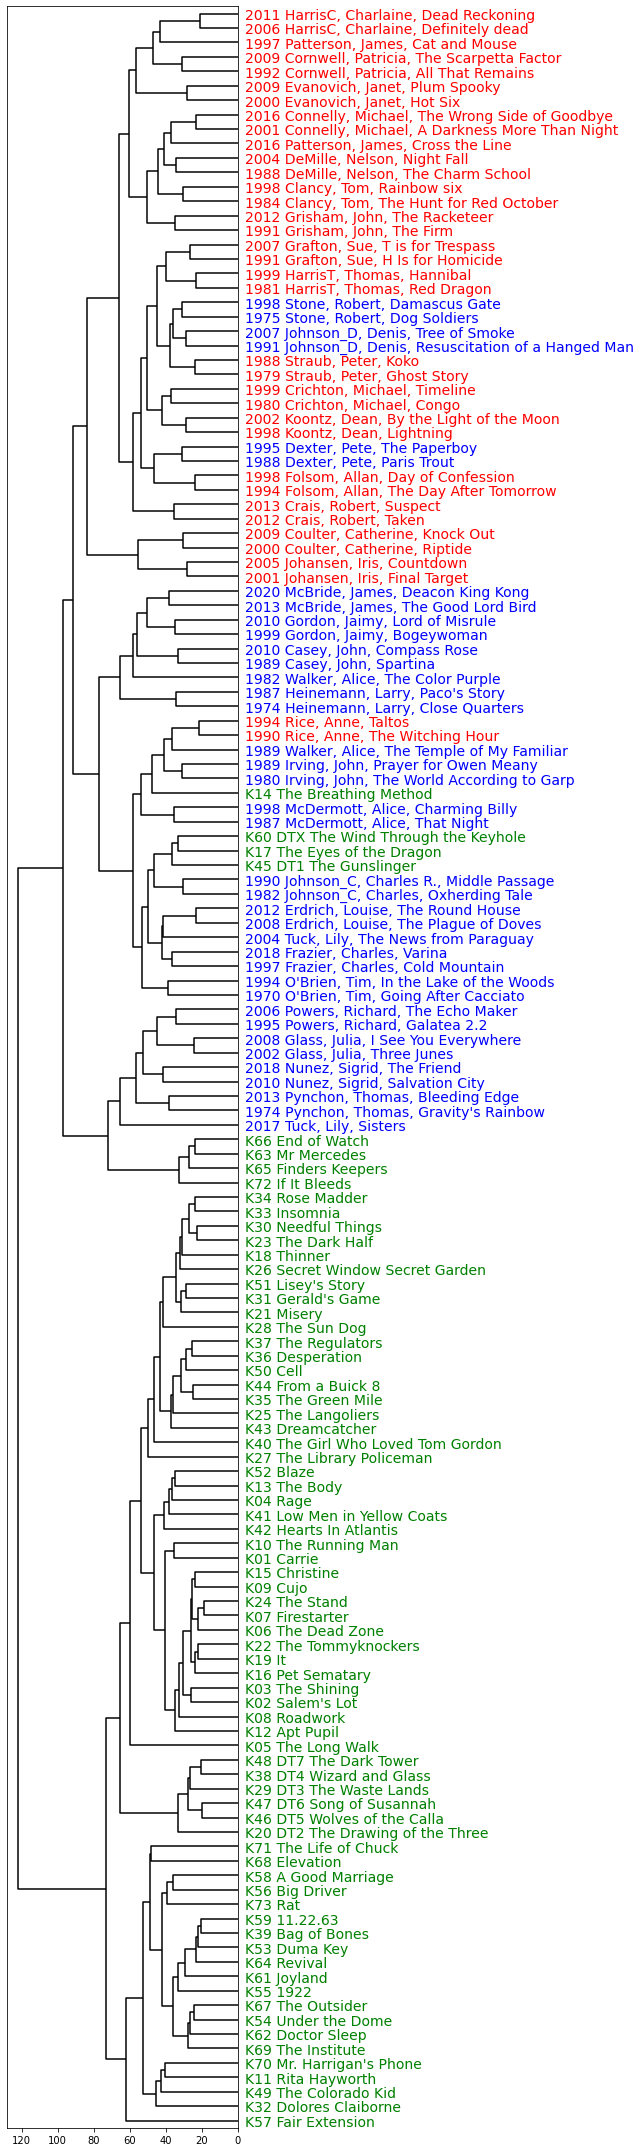

In [14]:
model = cluster.AgglomerativeClustering(n_clusters=None, distance_threshold=0., compute_full_tree=True, linkage='ward')
model = model.fit(X)
fig, ax = plt.subplots(figsize=(9, 30))
catdict = dict(zip(X.index, Xcategory_))
colormap = {'high': 'b', 'pop': 'r', 'king': 'g'}
plot_dendrogram(model, X.index, ax, catdict, colormap)
fig.tight_layout()
fig.savefig('dendogram.pdf'); fig.savefig('dendogram.png', dpi=150, facecolor='white', transparent=False);

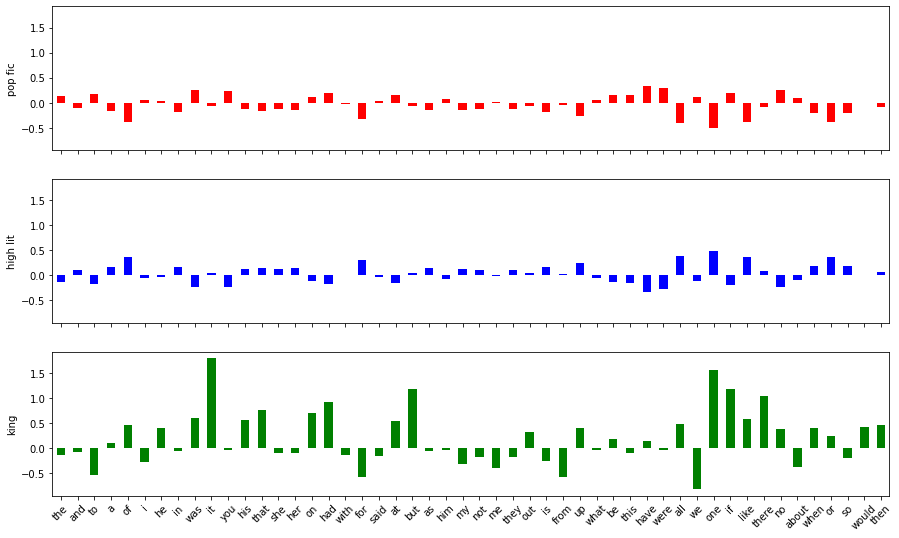

In [15]:
# Spike plot
fig, axes = plt.subplots(3, 1, figsize=(15, 9), sharey=True, sharex=True)
highvec[:50].plot.bar(ax=axes[1], color='b'); axes[1].set_ylabel('high lit')
popvec[:50].plot.bar(ax=axes[0], color='r'); axes[0].set_ylabel('pop fic')
X.loc[king, :].mean(axis=0)[:50].plot.bar(ax=axes[2], color='g', rot=45); axes[2].set_ylabel('king');

In [16]:
for name, subset in zip('king high pop'.split(), [king, high, pop]):
    print('Subset:', name)
    print('Most characteristic:', ', '.join(X.loc[subset, :].mean(axis=0).sort_values().tail(15).index))
    print('Most uncharacteristic:', ', '.join(X.loc[subset, :].mean(axis=0).sort_values().head(15).index))
    print()

Subset: king
Most characteristic: ones, kid, thought, one, sounded, least, began, idea, although, mouth, it, sound, mind, gone, almost
Most uncharacteristic: meet, moved, family, figure, attention, we, near, whether, minute, learned, met, worked, within, though, return

Subset: high
Most characteristic: way, whose, girls, dream, funny, among, fall, each, whole, every, one, sometimes, own, themselves, day
Most uncharacteristic: minutes, area, information, killed, phone, checked, realized, probably, check, opened, second, we're, okay, hell, door

Subset: pop
Most characteristic: door, hell, okay, we're, second, opened, check, probably, realized, checked, phone, killed, information, area, minutes
Most uncharacteristic: day, themselves, own, sometimes, one, every, whole, each, fall, among, funny, dream, girls, whose, way



In [17]:
for name, subset in zip('king high pop'.split(), [king, high, pop]):
    print('Subset:', name)
    print('Most characteristic:', ', '.join(X.loc[subset, :].mean(axis=0).sort_values().tail(15).index))
    print('Most uncharacteristic:', ', '.join(X.loc[subset, :].mean(axis=0).sort_values().head(15).index))
    print()

Subset: king
Most characteristic: ones, kid, thought, one, sounded, least, began, idea, although, mouth, it, sound, mind, gone, almost
Most uncharacteristic: meet, moved, family, figure, attention, we, near, whether, minute, learned, met, worked, within, though, return

Subset: high
Most characteristic: way, whose, girls, dream, funny, among, fall, each, whole, every, one, sometimes, own, themselves, day
Most uncharacteristic: minutes, area, information, killed, phone, checked, realized, probably, check, opened, second, we're, okay, hell, door

Subset: pop
Most characteristic: door, hell, okay, we're, second, opened, check, probably, realized, checked, phone, killed, information, area, minutes
Most uncharacteristic: day, themselves, own, sometimes, one, every, whole, each, fall, among, funny, dream, girls, whose, way



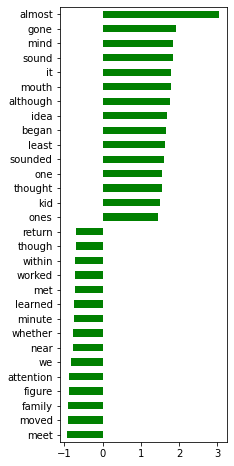

In [18]:
fig, ax = plt.subplots(figsize=(3, 8), sharey=True, sharex=True)
top = X.loc[king, :].mean(axis=0).sort_values()
pd.concat([top.head(15), top.tail(15)]).plot.barh(ax=ax, color='g');

## Classification: regularized logistic regression (scores with crossvalidation)

In [19]:
model = linear_model.LogisticRegressionCV(random_state=0, class_weight={'pop': 2, 'high': 1}, cv=5)
target = ['high'] * len(high) + ['pop'] * len(pop)
pred = model_selection.cross_val_predict(model, X.loc[high.append(pop), :], y=target, cv=model_selection.GroupKFold(3), groups=list(md1.loc[high.append(pop), 'author']))
print(metrics.classification_report(target, pred, digits=3))

              precision    recall  f1-score   support

        high      0.947     0.947     0.947        38
         pop      0.944     0.944     0.944        36

    accuracy                          0.946        74
   macro avg      0.946     0.946     0.946        74
weighted avg      0.946     0.946     0.946        74



In [20]:
# now train again without crossvalidation, get probability for each King book
model.fit(X.loc[high.append(pop), :], target)
prob = pd.DataFrame(model.predict_proba(X.loc[king]), index=king, columns=model.classes_)
prob['high'].to_csv('pred.csv')
prob

,high,pop
K01 Carrie,0.454648,0.545352
K02 Salem's Lot,0.392439,0.607561
K03 The Shining,0.405056,0.594944
K04 Rage,0.559380,0.440620
K05 The Long Walk,0.600367,0.399633
...,...,...
K69 The Institute,0.343822,0.656178
K70 Mr. Harrigan's Phone,0.553657,0.446343
K71 The Life of Chuck,0.820107,0.179893
K72 If It Bleeds,0.363916,0.636084


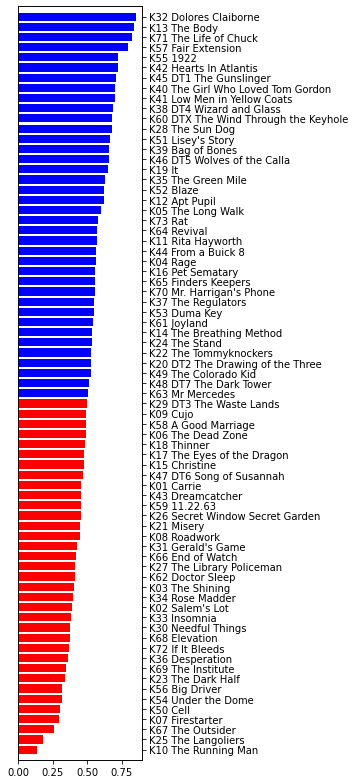

In [21]:
# probability that each King novel is high literary according to logistic regression
probh = prob.high.sort_values()
fig, ax = plt.subplots(figsize=(5, 11))  # , xlim=(0, 1))
ax2 = ax.twinx()
ax.set_yticks([])
ax2.barh(probh.index, probh, color=['r'] * (probh <= 0.5).sum() + ['b'] * (probh > 0.5).sum())
ax2.set_ylim(-1, len(probh))
ax2.set_xlabel('prob high lit'); # ax.set_ylabel('Stephen King novel');
ax2.figure.tight_layout()
ax2.figure.savefig('logregbarplot.pdf'); ax.figure.savefig('logreglineplot.png', dpi=150, facecolor='white', transparent=False);

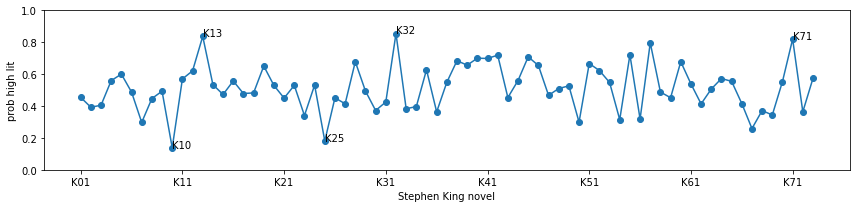

In [22]:
# probability that each King novel is high literary according to logistic regression
prob.index = [a.split()[0] for a in prob.index]
ax = prob.high.plot(figsize=(12, 3), ylabel='prob high lit', xlabel='Stephen King novel', marker='o', ylim=(0, 1));
# ax.set_xticks(range(len(prob.index))); ax.set_xticklabels(prob.index);
for n, (key, val) in enumerate(prob['high'].iteritems()):
    if val < 0.2 or val > 0.8:
        ax.annotate(key.split()[0], (n, val))
ax.figure.tight_layout()
ax.figure.savefig('logreglineplot.pdf'); #ax.figure.savefig('logreglineplot.png', dpi=150);

In [23]:
# Evaluation on King novels with literariness categorizations:
pred = model.predict(X.loc[king][~md.literariness.isna()])
true = md[~md.literariness.isna()].literariness
print(metrics.classification_report(true, pred, digits=3))

              precision    recall  f1-score   support

        high      0.706     0.706     0.706        17
         pop      0.615     0.615     0.615        13

    accuracy                          0.667        30
   macro avg      0.661     0.661     0.661        30
weighted avg      0.667     0.667     0.667        30



In [24]:
# confusion matrix
df = pd.DataFrame({'Actual': true, 'Predicted': pred}) # .replace({False: 'nonmention', True: 'mention'})                             
confusion = pd.crosstab(df['Actual'], df['Predicted'],
        rownames=['Actual'], colnames=['Predicted'],
        margins=True, margins_name='Total')
print(confusion)

Predicted  high  pop  Total
Actual                     
high         12    5     17
pop           5    8     13
Total        17   13     30


In [25]:
# Train and evaluate only on the 30 King novels with literariness labels (crossvalidated)
model = linear_model.LogisticRegressionCV(random_state=0, class_weight='balanced', cv=3)
pred = model_selection.cross_val_predict(model, X.loc[king][~md.literariness.isna()], y=md[~md.literariness.isna()].literariness)
print(metrics.classification_report(md[~md.literariness.isna()].literariness, pred, digits=3))

              precision    recall  f1-score   support

        high      0.714     0.588     0.645        17
         pop      0.562     0.692     0.621        13

    accuracy                          0.633        30
   macro avg      0.638     0.640     0.633        30
weighted avg      0.649     0.633     0.635        30



## Random baselines

In [26]:
model = dummy.DummyClassifier(strategy='constant', constant='pop')
model.fit(X.loc[high.append(pop), :], target)
pred = model.predict(X.loc[king][~md.literariness.isna()])
true = md[~md.literariness.isna()].literariness
print(metrics.classification_report(true, pred, digits=3, zero_division=0))

              precision    recall  f1-score   support

        high      0.000     0.000     0.000        17
         pop      0.433     1.000     0.605        13

    accuracy                          0.433        30
   macro avg      0.217     0.500     0.302        30
weighted avg      0.188     0.433     0.262        30



In [27]:
# Baseline scores
model = dummy.DummyClassifier(strategy='most_frequent')
model.fit(X.loc[high.append(pop), :], target)
pred = model.predict(X.loc[king][~md.literariness.isna()])
true = md[~md.literariness.isna()].literariness
print(metrics.classification_report(true, pred, digits=3, zero_division=0))

              precision    recall  f1-score   support

        high      0.567     1.000     0.723        17
         pop      0.000     0.000     0.000        13

    accuracy                          0.567        30
   macro avg      0.283     0.500     0.362        30
weighted avg      0.321     0.567     0.410        30



In [28]:
for strategy in ['uniform', 'stratified']:
    print(strategy)
    l = []
    for n in range(10):
        model = dummy.DummyClassifier(strategy='uniform', random_state=n)
        model.fit(X.loc[high.append(pop), :], target)
        pred = model.predict(X.loc[king][~md.literariness.isna()])
        true = md[~md.literariness.isna()].literariness
        l.append(metrics.f1_score([0 if a == 'high' else 1 for a in true], [0 if a == 'high' else 1 for a in pred], average='macro'))
    print(l)
    print(pd.Series(l).describe())
    print()

uniform
[0.5999999999999999, 0.6296296296296298, 0.4666666666666667, 0.4570135746606335, 0.5248868778280543, 0.4994438264738599, 0.53125, 0.42760942760942766, 0.4994438264738599, 0.41714285714285715]
count    10.000000
mean      0.505309
std       0.069269
min       0.417143
25%       0.459427
50%       0.499444
75%       0.529659
max       0.629630
dtype: float64

stratified
[0.5999999999999999, 0.6296296296296298, 0.4666666666666667, 0.4570135746606335, 0.5248868778280543, 0.4994438264738599, 0.53125, 0.42760942760942766, 0.4994438264738599, 0.41714285714285715]
count    10.000000
mean      0.505309
std       0.069269
min       0.417143
25%       0.459427
50%       0.499444
75%       0.529659
max       0.629630
dtype: float64

